In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

batch_size = 8

cuda


In [3]:
train_mod1_file = 'phase2_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod2.h5ad'
# test_mod1_file = 'phase2_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod1.h5ad'
# test_mod1_file = 'phase2_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
# input_test_mod1 = ad.read_h5ad(test_mod1_file)
# input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
# print(input_test_mod1)
# print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
pro_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod2.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod2.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod2.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod2.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod2.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod2.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod2.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod2.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod2.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [10]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [11]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

In [32]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)

In [13]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

In [14]:
# standardize based on each batch
for i in range(len(train_input)):
    train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

for i in range(len(train_output)):
    train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

for i in range(len(val_input)):
    val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

for i in range(len(val_output)):
    val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [15]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)

In [16]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)

In [17]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()

In [18]:
train_output = train_output[:, 0]
train_output.shape

torch.Size([37254])

In [19]:
val_output = val_output[:, 0]
val_output.shape

torch.Size([28921])

In [20]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [21]:
input_feature = train_input.shape[1]
output_feature = 1

In [22]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//2)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, output_feature)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        x = self.relu(x)
        
        x = self.linear4(x)
        x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [23]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 10 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            print('Epoch ', epoch, 'Train_loss: ', train_loss*1000, ' Validation_loss: ', val_loss*1000)
           
        # if epoch % (num_epochs//10) == 0:
            train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred_output, val_pred_output

In [24]:
num_epochs = 200
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 128

model = Autoencoder()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_pred_output, val_pred_output = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output)

Epoch  0 Train_loss:  155.88679909706116  Validation_loss:  281.99684619903564
Epoch  10 Train_loss:  43.33855211734772  Validation_loss:  144.36937868595123
Epoch  20 Train_loss:  44.632188975811005  Validation_loss:  116.90541356801987
Epoch  30 Train_loss:  37.795111536979675  Validation_loss:  107.9816073179245
Epoch  40 Train_loss:  57.596780359745026  Validation_loss:  103.44807803630829
Epoch  50 Train_loss:  72.63591885566711  Validation_loss:  107.28997737169266
Epoch  60 Train_loss:  71.0814893245697  Validation_loss:  105.21329194307327
Epoch  70 Train_loss:  76.54187083244324  Validation_loss:  106.0478612780571
Epoch  80 Train_loss:  85.27271449565887  Validation_loss:  110.06201058626175
Epoch  90 Train_loss:  87.49005198478699  Validation_loss:  111.50969564914703
Epoch  100 Train_loss:  100.97230970859528  Validation_loss:  115.58610945940018
Epoch  110 Train_loss:  112.06918209791183  Validation_loss:  119.72486227750778
Epoch  120 Train_loss:  116.33305251598358  Vali

In [25]:
print('batch length of s1d1:', len(batch_s1d1))
print('batch length of s1d2:', len(batch_s1d2))
print('batch length of s1d3:', len(batch_s1d3))
print('batch length of s2d1:', len(batch_s2d1))
print('batch length of s2d4:', len(batch_s2d4))
print('batch length of s2d5:', len(batch_s2d5))
print('batch length of all batches:', len(batch_train))

batch length of s1d1: 4721
batch length of s1d2: 4464
batch length of s1d3: 5484
batch length of s2d1: 9353
batch length of s2d4: 5026
batch length of s2d5: 8206
batch length of all batches: 37254


In [26]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

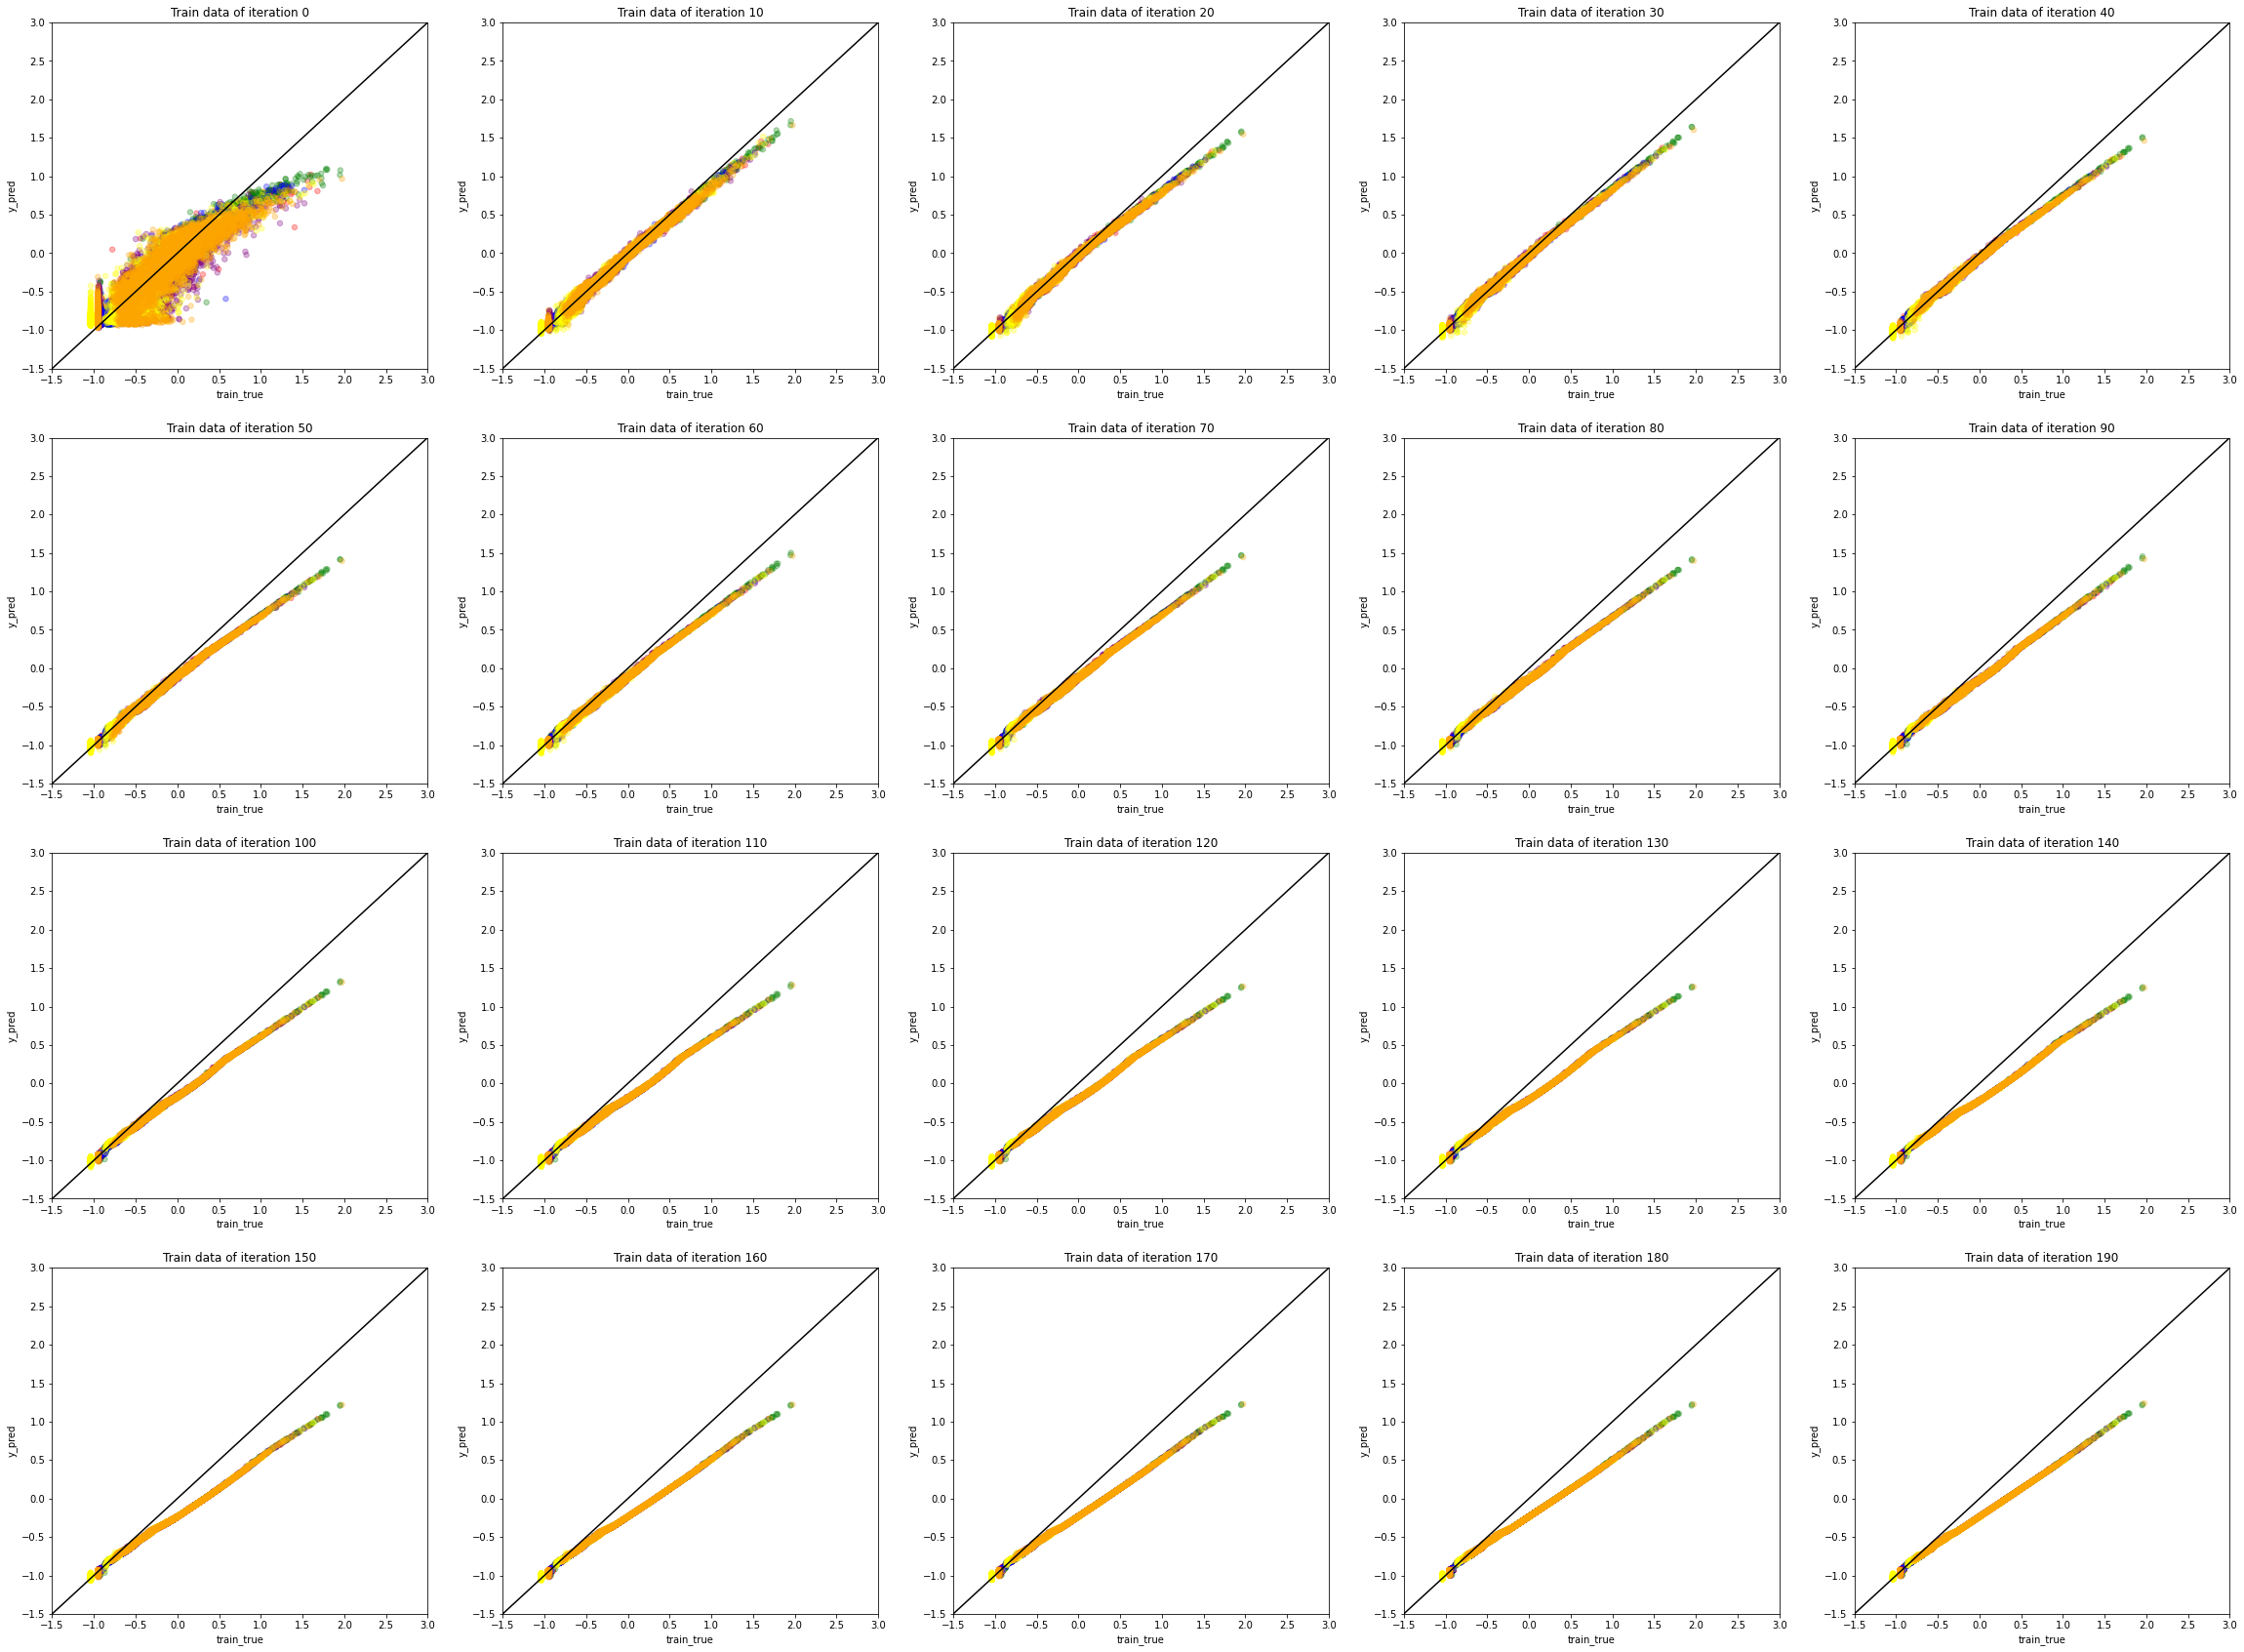

In [27]:
figure, ax = plt.subplots(4, 5, figsize = (40, 30))
ax = ax.flatten()
for i in range(20):
    train_pred_np = train_pred_output[i][0]
    train_output_np = train_pred_output[i][1]
    ax[i].scatter(train_output_np, train_pred_np, c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
    ax[i].plot([-1.5, 3], [-1.5, 3], 'k-')
    ax[i].set_xlim([-1.5, 3])
    ax[i].set_ylim([-1.5, 3])
    ax[i].set_title('Train data of iteration '+str(i*10))
    ax[i].set_xlabel('train_true')
    ax[i].set_ylabel('y_pred')

In [33]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

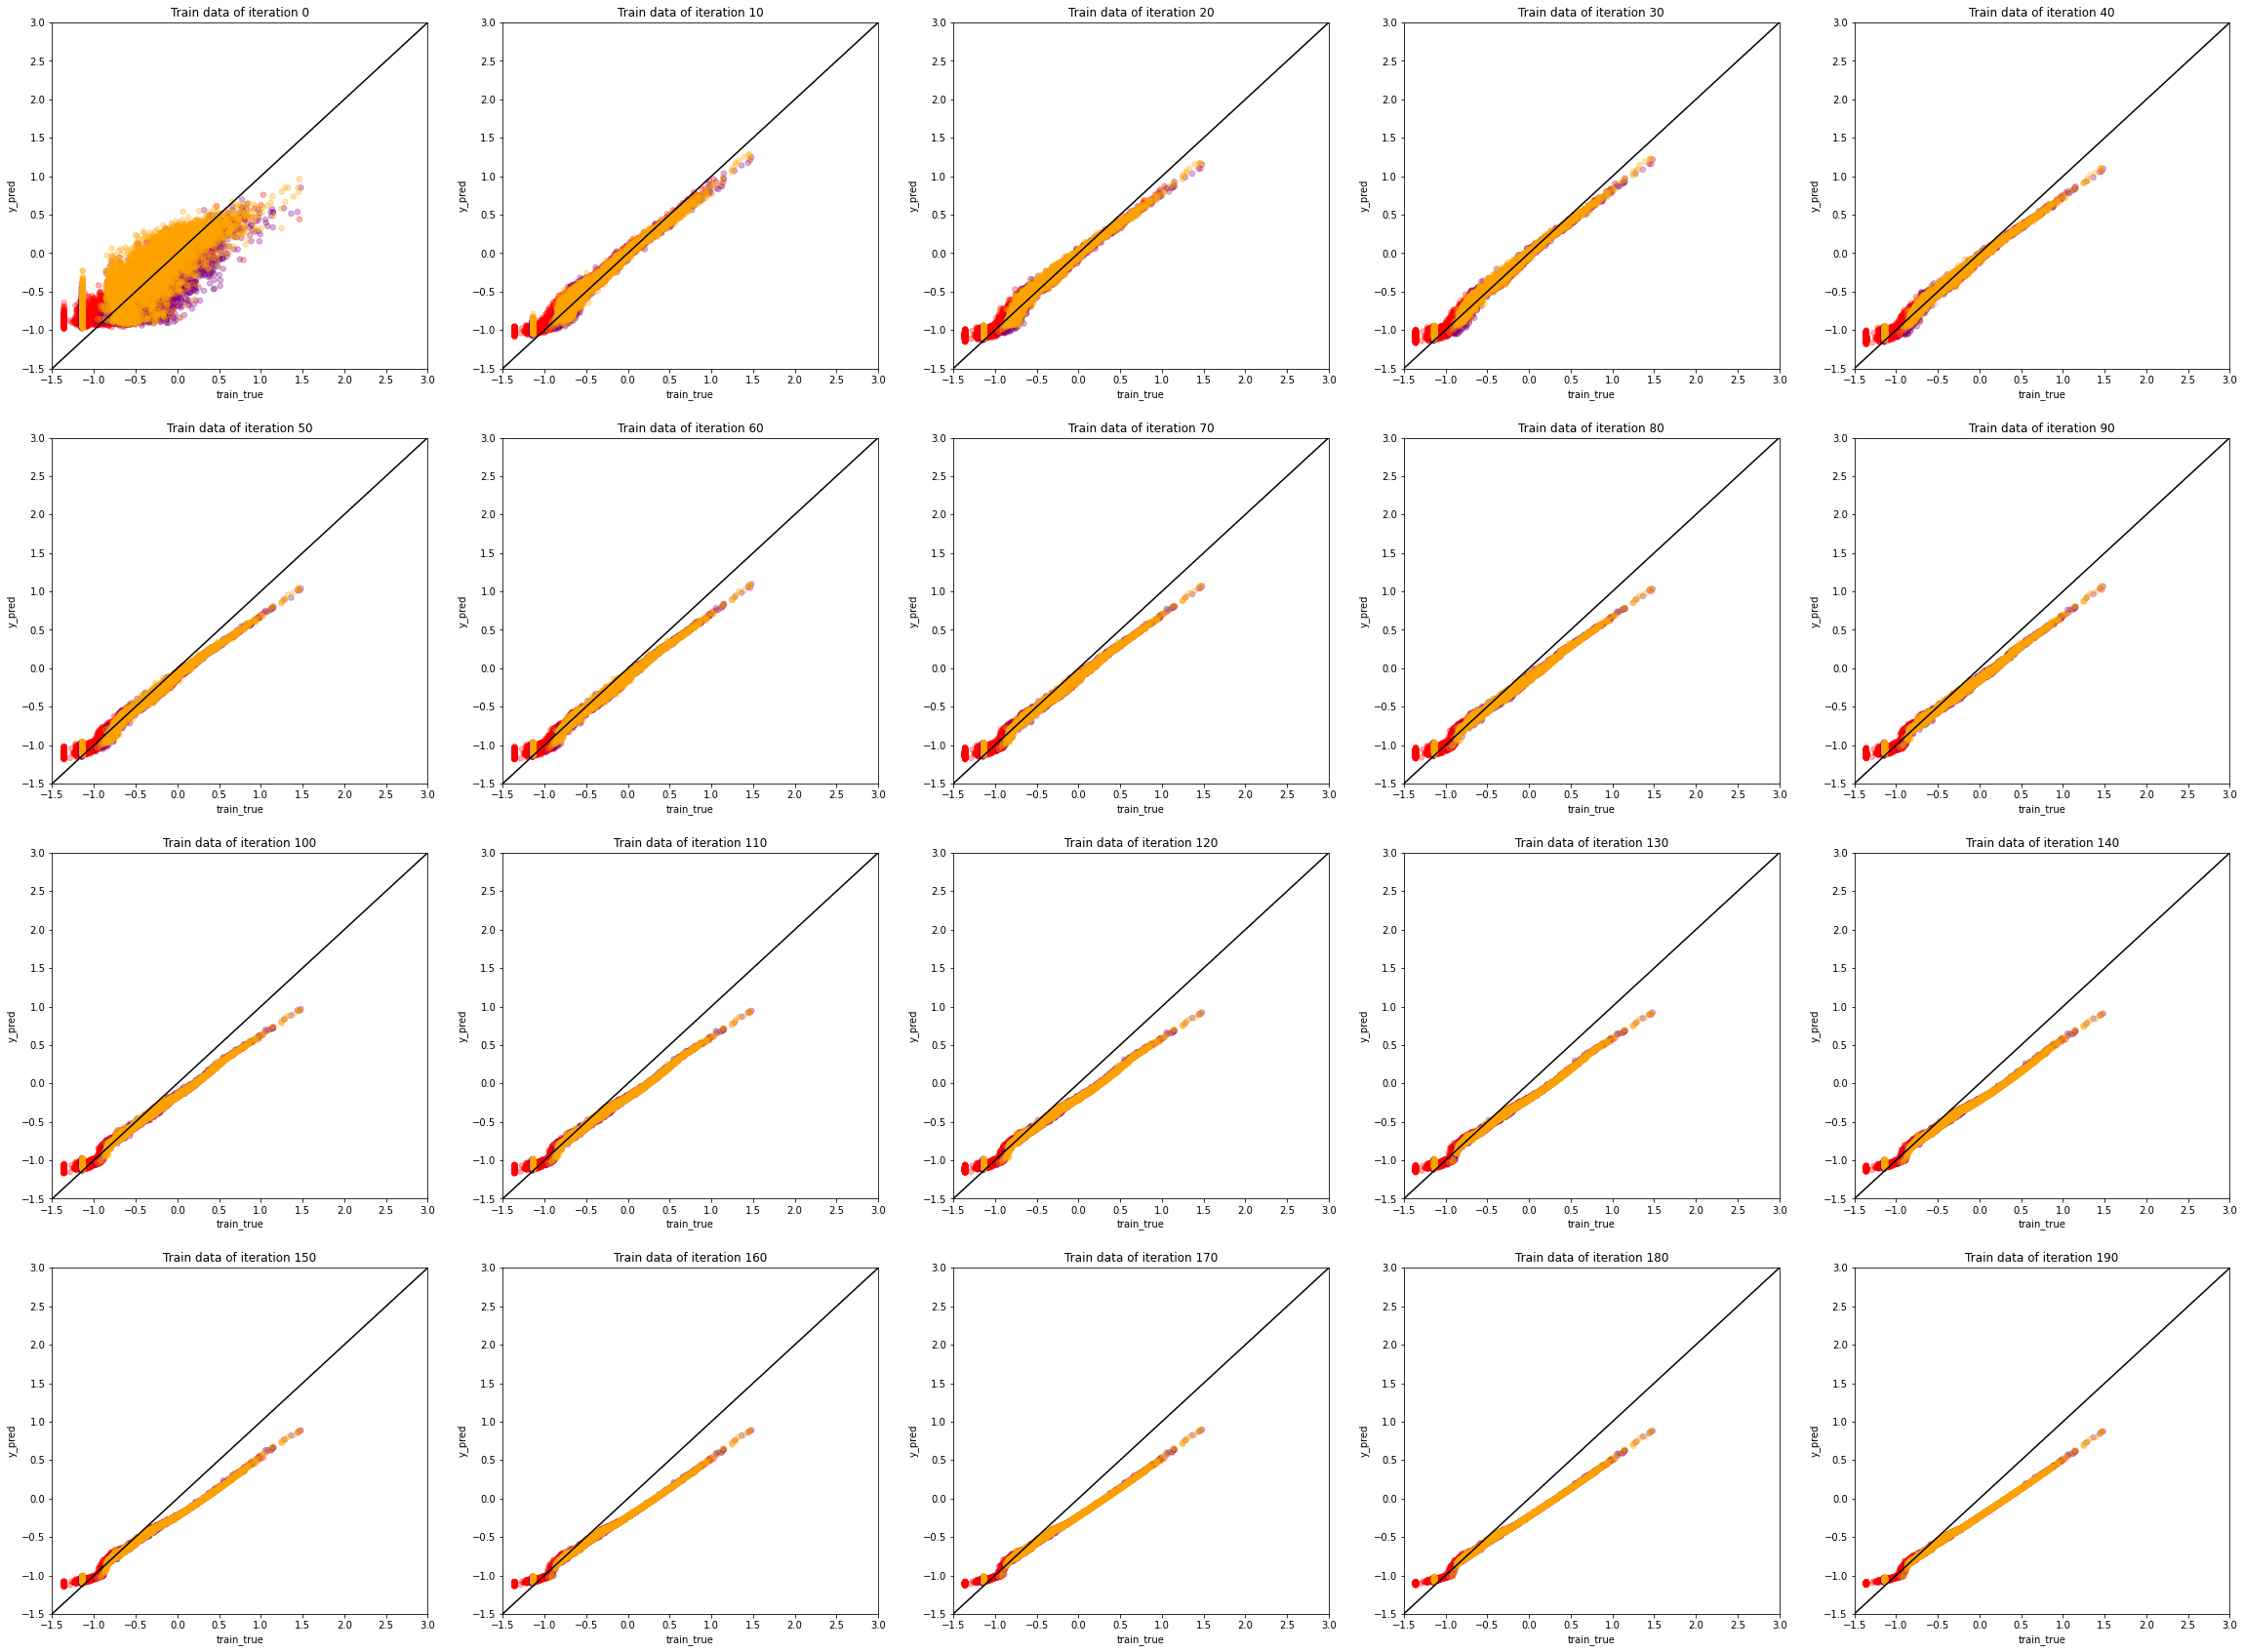

In [34]:
figure, ax = plt.subplots(4, 5, figsize = (40, 30))
ax = ax.flatten()
for i in range(20):
    train_pred_np = val_pred_output[i][0]
    train_output_np = val_pred_output[i][1]
    ax[i].scatter(train_output_np, train_pred_np, c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
    ax[i].plot([-1.5, 3], [-1.5, 3], 'k-')
    ax[i].set_xlim([-1.5, 3])
    ax[i].set_ylim([-1.5, 3])
    ax[i].set_title('Train data of iteration '+str(i*10))
    ax[i].set_xlabel('train_true')
    ax[i].set_ylabel('y_pred')